<a href="https://colab.research.google.com/github/patrick-seib/retail-sales-forecasting-project/blob/main/CanadianRetailSalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from pmdarima.arima import arima
from google.colab import drive

drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/My Drive/416_Data/2010000801-eng (1).csv', header=0, names=['date', 'value'])

Mounted at /content/drive/


In [ ]:
df = df.replace(',', '', regex=True)
df['date'] = pd.to_datetime(df['date'])
df['value'] = pd.to_numeric(df['value'])
df.head()

,date,value
0,1991-01-01,12588862
1,1991-02-01,12154321
2,1991-03-01,14337072
3,1991-04-01,15108570
4,1991-05-01,17225734


In [ ]:
# setting up training/test data
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['value'].values
y_test = test_data['value'].values
y_full = df['value'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

304 train samples
77 test samples


In [ ]:
def plot_differences(dataset):
    #plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})

    # Original Series
    fig, axes = plt.subplots(3, 2, sharex=True)
    axes[0, 0].plot(dataset)
    axes[0, 0].set_title('Original Series')
    plot_acf(dataset, ax=axes[0, 1])

    # 1st Differencing
    axes[1, 0].plot(dataset.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(dataset.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(dataset.diff().diff())
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(dataset.diff().diff().dropna(), ax=axes[2, 1])

    plt.show()

    # Partial Auto-Correlation plot of 1st differenced series
    plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

    fig, axes = plt.subplots(1, 2, sharex=True)
    axes[0].plot(dataset.diff())
    axes[0].set_title('1st Differencing')
    axes[1].set(ylim=(0, 5))
    plot_pacf(dataset.diff().dropna(), ax=axes[1])

    plt.show()

    # Auto-Correlation plot of 1st differenced series
    plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

    fig, axes = plt.subplots(1, 2, sharex=True)
    axes[0].plot(dataset.diff())
    axes[0].set_title('1st Differencing')
    axes[1].set(ylim=(0, 1.2))
    plot_acf(dataset.diff().dropna(), ax=axes[1])

    plt.show()


def find_differencing_term_train(train_set):
    kpss_diffs = ndiffs(train_set, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(train_set, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)
    return n_diffs


def forecast_one_step(model):
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])


def test_model(model, y_train, test_data):
    forecasts = []
    confidence_intervals = []

    for new_ob in y_test:
        fc, conf = forecast_one_step(model)
        forecasts.append(fc)
        confidence_intervals.append(conf)
        model.update(new_ob)

    print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
    print(f"SMAPE: {smape(y_test, forecasts)}")
    display_forecasts(forecasts, confidence_intervals, y_train, y_test, test_data)


def display_forecasts(forecasts, confidence_intervals, y_train, y_test, test_data):
    #plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})
    plt.plot(y_train, color='blue', label='Training Data')
    plt.plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Sales')

    plt.plot(test_data.index, y_test, color='red', label='Actual Sales')
    plt.title("Retail Sales in Canada")
    plt.xlabel("Month")
    plt.ylabel('Total Retail Sales')

    plt.legend()
    plt.show()

    plt.plot(y_train, color='blue', label='Training Data')
    plt.plot(test_data.index, forecasts, color='green',
             label='Predicted Sales')

    plt.title('Retail Sales Predictions & Confidence Intervals')
    plt.xlabel('Month')
    plt.ylabel('Total Retail Sales')

    conf_int = np.asarray(confidence_intervals)
    plt.fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

    plt.legend()
    plt.show()

In [ ]:
n_diffs = find_differencing_term_train(y_full)
n_diffs

1

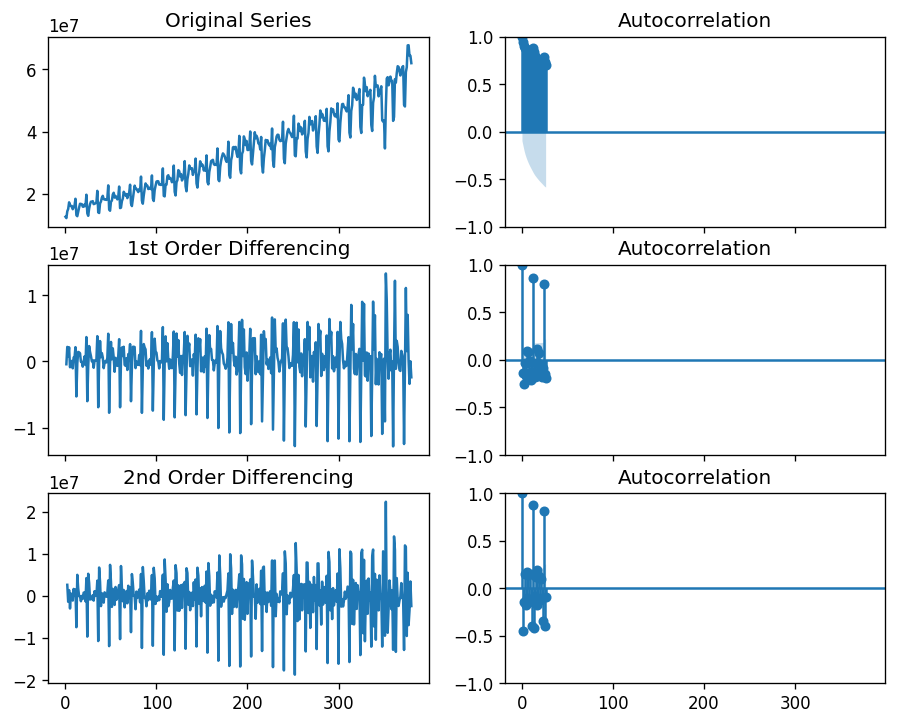

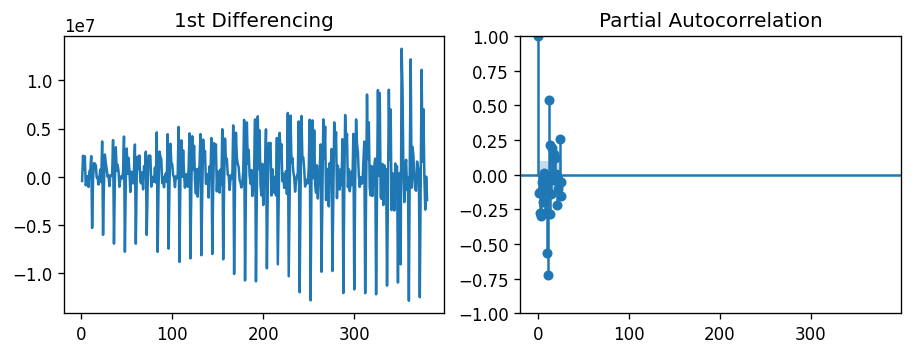

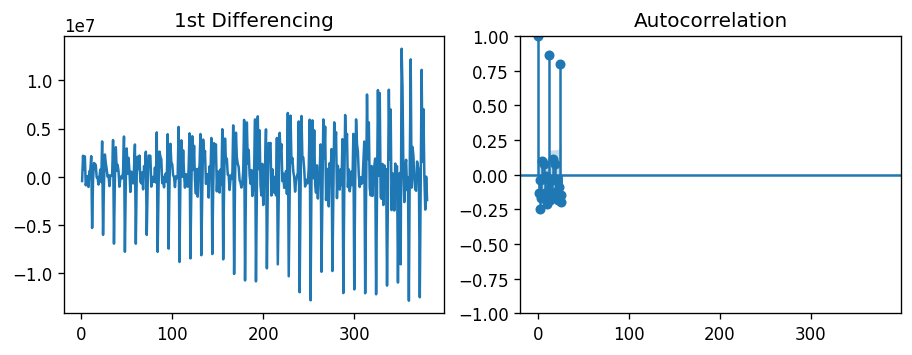

In [ ]:
plot_differences(df['value'])

In [ ]:
auto = pm.auto_arima(y_full, max_p=6, max_q=6, m=12, seasonal=True,
                     d=n_diffs, trace=True, max_order=None,
                     error_action='ignore',
                     suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12281.279, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12612.465, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12342.072, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12426.126, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12610.893, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=12360.667, Time=2.15 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=12284.103, Time=3.66 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=12283.261, Time=9.14 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=12278.826, Time=8.61 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=12315.524, Time=1.74 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=8.19 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=12291.006, Time=4.97 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=12306.814, Time=2.79 sec
 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=7.19 sec
 ARIMA(2,1,3)(1,0

Mean squared error: 9913445138365.719
SMAPE: 3.7594806204187083


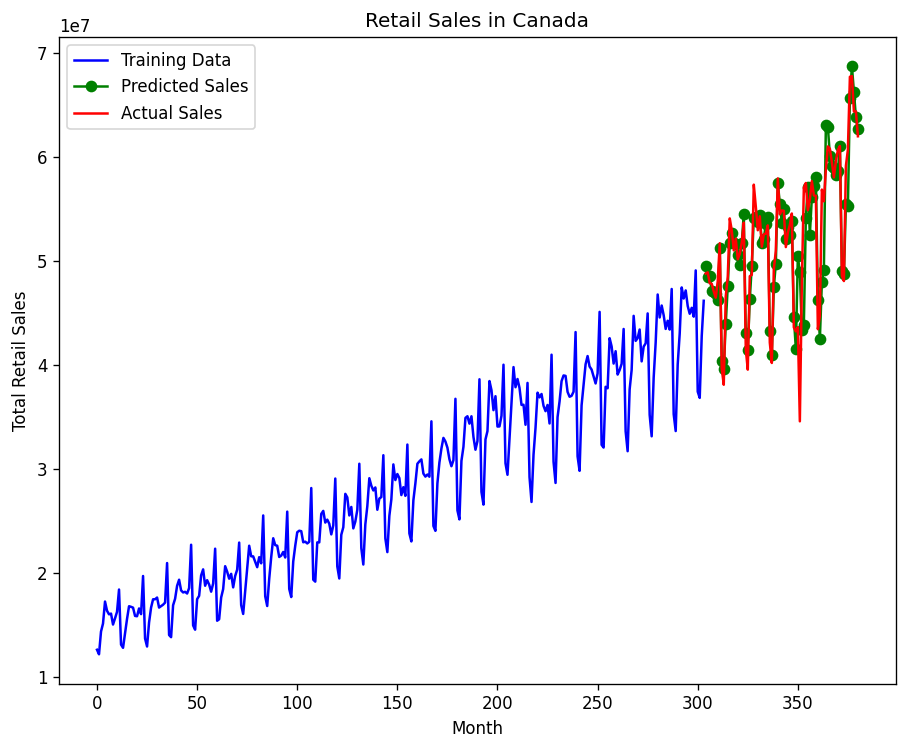

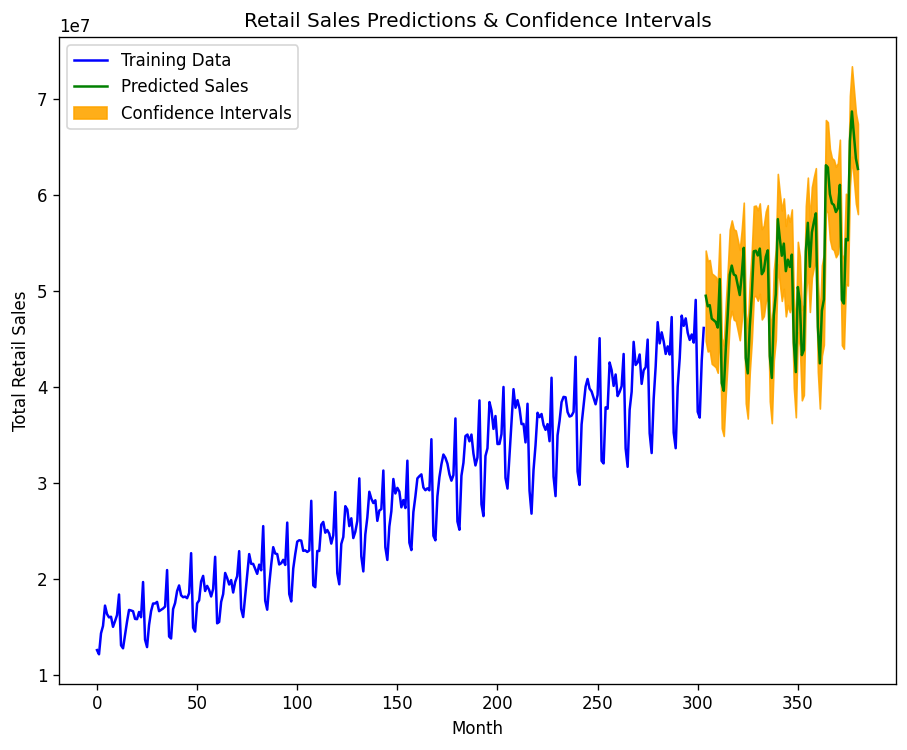

[62324822.19250128 62973875.2499657  62859050.32965155]
***** FULL MODEL *****
[62508083.24424602 63826313.55809502 64441781.15773305]


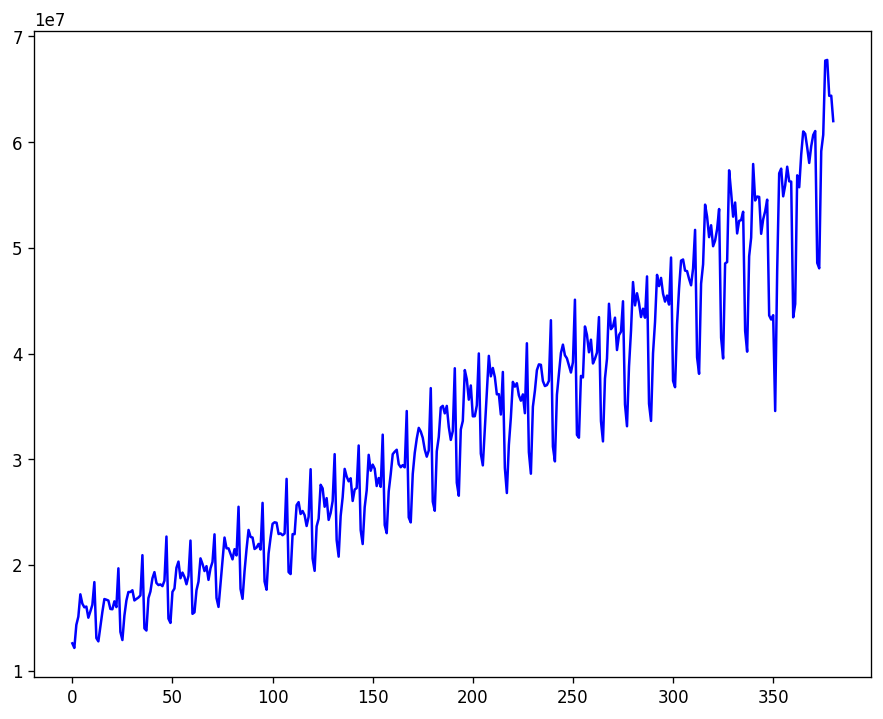

In [ ]:
model = auto.fit(y_train)
test_model(model, y_train, test_data)
print(model.predict(n_periods=3))

print("***** FULL MODEL *****")
model = auto.fit(y_full)
print(model.predict(n_periods=3))

plt.plot(y_full,color='blue', label='Full Data')